Let’s say you are trying to use a noisy, blurred, low resolution, heavily quantized video feed to estimate the x,y position of a ball.  The primary objective is to estimate the position of the ball as accurately as possible, and as quickly as possible!

Here is what we know:
    The field of view of the camera is dark (pixel intensity 0), except for a single ball with uniform brightness (pixel intensity 7) 
    The ball is exactly 10 pixels in diameter, and has perfectly elastic collisions will the four “walls” bounding the square field of view of the camera
    There are no external forces acting on the ball (no gravity, no air resistance)
    The camera's CCD has 101x101 pixels, each with 3-bit intensity resolution [0,7] (greyscale)
    The camera’s CCD is noisy. Each pixel has noise ~unif(0,5).  This noise is uncorrelated from pixel to pixel, and frame to frame.
    The ball’s initial position is pixel [0,0] but its initial velocity vector is unknown. The maximum velocity is 7.5 pixels per frame.

Here are the deliverables:
    Python simulation of this system. Please comment your code thoroughly, as it will be reviewed in detail.  If you use any open source code, please include citations.
    A dozen slides containing:
        Block diagram depicting your simulation structure
        Why you chose the algorithms you did (what else did you consider?)
        Plot of estimation accuracy vs frame count (does it converge? Any residual “steady state” error in the long run? Does performance depend on initial condition?)
        Some analytical justification for the simulation results you are seeing (did simulation agree with analytical? If so, why? If not, why not?)
        Estimate of total processing resources required to run your system in real time (MAC operations/frame)
        What would you do differently in your approach if you had more time?
        What did you find most challenging about this project

In [1]:
# Imports (Run once)
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pdb # For debugging
import cairo 
import math
import cv2
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral)
from skimage import (feature, measure)
from scipy import ndimage
import time
import scipy

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# This function adds uniformly distributed noise to each frame and quantizes it
def add_noise(x, lim_low=0.0, lim_high=6.0, bitdepth=3,rs=np.random.RandomState(seed=42)):
    
    b = rs.uniform(low=lim_low, high=lim_high, size=x.shape) + x # Add uniform noise
    adu = b.astype(np.int) # Convert to discrete numbers
    max_adu = np.int(2**bitdepth - 1)
    adu[adu>max_adu] = max_adu # Models pixel saturation

    return adu

In [3]:
# Creates a 101x101 pixel greyscale image with a illuminated, filled circle of radius: radius at position: pos.
def create_frame(pos, radius):
    base_img = np.zeros((num_pixels, num_pixels,4), dtype=np.uint8) # Should be black, 101x101 pixel
    surface = cairo.ImageSurface.create_for_data(
        base_img, cairo.FORMAT_ARGB32, num_pixels, num_pixels)
    cr = cairo.Context(surface)
    cr.set_source_rgb(1.0,1.0,1.0)
    cr.paint()
    cr.arc(pos[0], pos[1], radius, 0, 2*math.pi)
    cr.set_source_rgb(0.0,0.0,0.0)
    cr.stroke_preserve()
    cr.fill()
    circ_img = base_img[:,:,0]
    circ_img = (1 - (circ_img/circ_img.max())) * 2.0 # intensity of circle
    
    return circ_img

In [4]:
def create_noisy_frame(pos, radius):
    circ_img = create_frame(pos, radius)
    adu = add_noise(circ_img)
    
    return adu

In [5]:
# Method 1 for finding the position of the circle 
def find_approx(sig_gaus, num_sig):
    
    # This section first performs an averaging operation to surpress high frequencies (noise).
    # Then it performs a thresholding operation to identify high intensity sections and preserve gradients.
    denoised = ndimage.filters.gaussian_filter(adu,sig_gaus)
    denoised[denoised < np.amax(denoised)-num_sig*np.std(denoised)] = 0
    
    # This function determines regions of the image and their properties (area, centroid, convex hull, etc.)
    regions = measure.regionprops(denoised)

    # Find the region with a major axis of length closest to 10 (diameter of our circle)
    # I tried to implement it with standard deviation, which is possible. There was an
    # occasional circumstance in which this wouldn't work. Due to time constraints, I used
    # the diameter.
    best_i = 1000
#     best_std = 1000
    best_dist = 1000
    for i in range(len(regions)):
        prop = regions[i]
        if (len(prop.coords) > 10):
            std_dev = np.std(prop.coords)
            dist = math.fabs(prop.major_axis_length-10)
#             if (std_dev < best_std):
            if (dist < best_dist):
                best_i = i
                best_dist = dist
    
    # Return the best-matching region's radius and centroid
    prop = regions[best_i]
    approx_radius = prop.major_axis_length/2
    approx_pos = prop.centroid
    approx_pos_ad = (approx_pos[1]-half_window, -approx_pos[0]+half_window)
    
    return denoised, approx_pos_ad, approx_radius, approx_pos


In [6]:
# Setup
offset = 0
num_pixels = 101
half_window = (num_pixels-1)/2
vel = [random.uniform(-7.5,7.5) for i in range(2)] # generate a vector with a random x and y velocity
pos = [half_window+offset,half_window+offset] # initial position
radius = 5

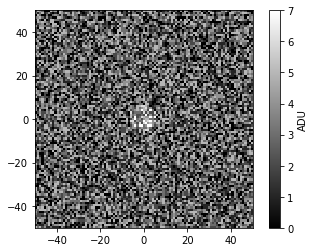

In [7]:
adu = create_noisy_frame(pos, radius)

fig, ax = plt.subplots(nrows=1, ncols=1)
img = ax.imshow(adu,cmap='gray')
img.set_extent([-half_window, half_window, -half_window, half_window])
cb  = plt.colorbar(img)
cb.set_label('ADU')

/home/anirudh/.local/lib/python3.5/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/anirudh/.local/lib/python3.5/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


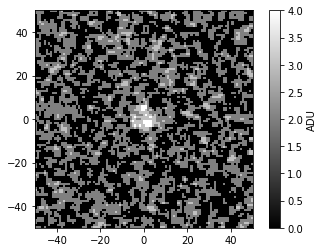

In [8]:
denoised, approx_pos_ad, approx_radius, approx_pos = find_approx(0.8, 4)

fig, ax = plt.subplots(nrows=1, ncols=1)
img2 = ax.imshow(denoised, cmap='gray')
img2.set_extent([-half_window, half_window, -half_window, half_window])
cb  = plt.colorbar(img2)
cb.set_label('ADU')

(73.5945945945946, 67.27027027027027)
[74.4457321483538, 71.1312587969521]
6.79676992382039


<IPython.core.display.Javascript object>


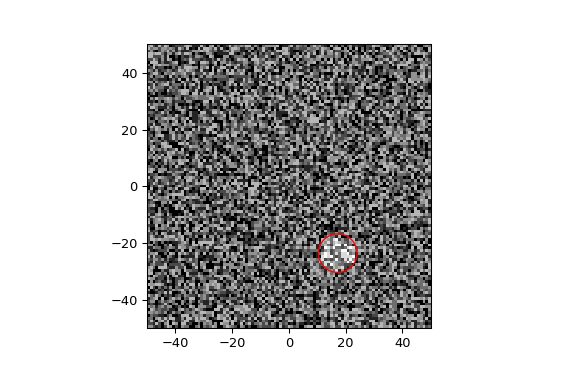

In [113]:
adu_cp = adu.copy()

print(approx_pos)
print(pos)
print(approx_radius)

circle1 = plt.Circle(approx_pos_ad,approx_radius,color='r', fill=False)
fig, ax = plt.subplots(nrows=1, ncols=1)
img3 = ax.imshow(adu_cp, cmap='gray')
ax.add_artist(circle1)
img3.set_extent([-half_window, half_window, -half_window, half_window])

<IPython.core.display.Javascript object>


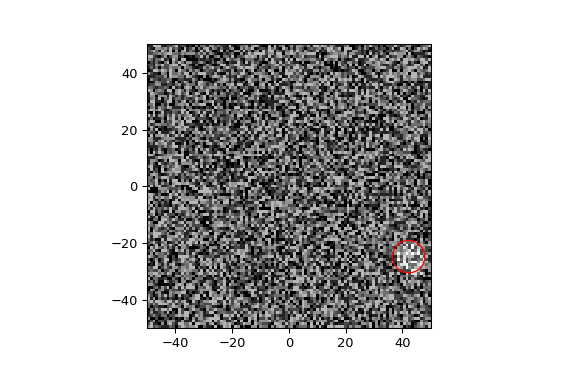

In [71]:
# Method 2 for finding the position of the circle

# We leverage the fact that we know our noisy image has a circle. Create a frame with 
# a smaller circle size and no noise. Perform a 2d convolution to find the correlation
# of the noiseless image with the noisy one. The brightest region in the correlation should
# be the circle.
circ_img = create_frame([0,0], 3)
adu_ac = scipy.signal.fftconvolve(adu, circ_img[::-1,::-1])
adu_reshape = adu_ac[-101:,-101:]

# Perform thresholding to get rid of the last of the noise.
# Find the indices of the non-zero elements
adu_reshape[adu_reshape < np.amax(adu_reshape)-np.std(adu_reshape)] = 0
nnz = np.nonzero(adu_reshape)

# Find the centroid by averaging these indices
x_mean = np.mean(nnz[1])-half_window
y_mean = -np.mean(nnz[0])+half_window


circle1 = plt.Circle((x_mean, y_mean),approx_radius,color='r', fill=False)

# fig, ax = plt.subplots(nrows=1, ncols=1)
# img2 = ax.imshow(adu_reshape, cmap='gray')
# img2.set_extent([-half_window, half_window, -half_window, half_window])
# cb  = plt.colorbar(img2)
# cb.set_label('ADU')

fig, ax = plt.subplots(nrows=1, ncols=1)
img3 = ax.imshow(adu_cp, cmap='gray')
ax.add_artist(circle1)
img3.set_extent([-half_window, half_window, -half_window, half_window])

<IPython.core.display.Javascript object>


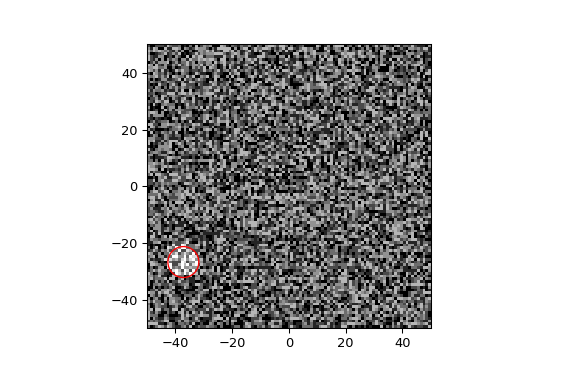

/home/anirudh/.local/lib/python3.5/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/anirudh/.local/lib/python3.5/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


0.9864933872349343


In [126]:
%matplotlib notebook

pos = [half_window, half_window]
vel = [random.uniform(-7.5,7.5) for i in range(2)]

fig,ax = plt.subplots(1,1)
ax.set_xlim(-half_window,half_window)
ax.set_ylim(-half_window,half_window)

errs = []

for i in range(50):    
    
    # Elastic collision
    if pos[0] >= (half_window*2)-radius:
        vel[0] *= -1
    if pos[0] <= radius:
        vel[0] *= -1
    if pos[1] >= (half_window*2)-radius:
        vel[1] *= -1
    if pos[1] <= radius:
        vel[1] *= -1
    
    adu = create_noisy_frame(pos, radius)
    denoised, approx_pos_ad, approx_radius, approx_pos = find_approx(0.8, 4)
    
    adu_cp = adu.copy()
    circle1 = plt.Circle(approx_pos_ad,approx_radius,color='r', fill=False)
    
    ax.clear()
    img = ax.imshow(adu_cp, cmap='gray')
    ax.add_artist(circle1)
    img.set_extent([-half_window, half_window, -half_window, half_window])
    
    fig.canvas.draw()
    
    errs.append(math.sqrt((pos[0]-approx_pos[1])**2+(pos[1]-approx_pos[0])**2))
    
    # Update position of the circle
    pos[0] += vel[0]
    pos[1] += vel[1]
    time.sleep(0.01)

avg_err = np.mean(errs)
errs1 = errs
print(avg_err)

<IPython.core.display.Javascript object>


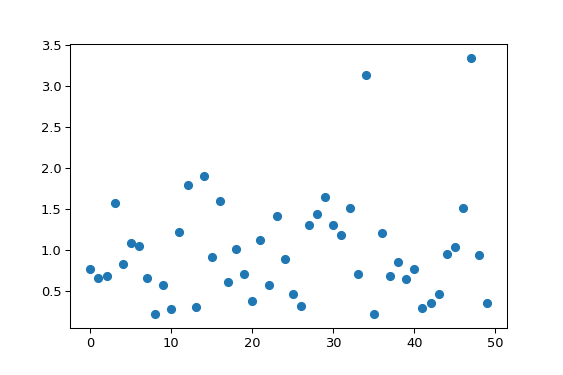

In [127]:
fig,ax = plt.subplots(1,1)
ax.scatter(range(len(errs1)),errs1)
plt.show()

<IPython.core.display.Javascript object>


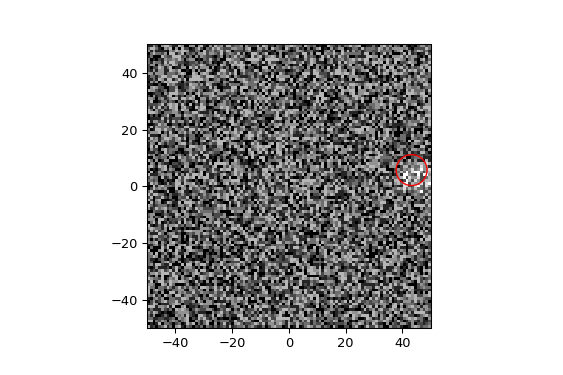

2.9460657536425856


In [128]:
%matplotlib notebook

pos = [half_window, half_window]
vel = [random.uniform(-7.5,7.5) for i in range(2)]

fig,ax = plt.subplots(1,1)
ax.set_xlim(-half_window,half_window)
ax.set_ylim(-half_window,half_window)

errs = []

for i in range(50):    
    # Elastic collision
    if pos[0] >= (half_window*2)-radius:
        vel[0] *= -1
    if pos[0] <= radius:
        vel[0] *= -1
    if pos[1] >= (half_window*2)-radius:
        vel[1] *= -1
    if pos[1] <= radius:
        vel[1] *= -1
    
    adu = create_noisy_frame(pos, radius)
    circ_img = create_frame([0,0], 3)
    adu_ac = scipy.signal.fftconvolve(adu, circ_img[::-1,::-1])

    adu_reshape = adu_ac[-101:,-101:]
    adu_reshape[adu_reshape < np.amax(adu_reshape)-np.std(adu_reshape)] = 0
    nnz = np.nonzero(adu_reshape)

    x_mean = np.mean(nnz[1])-half_window
    y_mean = -np.mean(nnz[0])+half_window
    
    adu_cp = adu.copy()
    circle1 = plt.Circle((x_mean, y_mean),approx_radius,color='r', fill=False)
    
    ax.clear()
    img = ax.imshow(adu_cp, cmap='gray')
    ax.add_artist(circle1)
    img.set_extent([-half_window, half_window, -half_window, half_window])
    
    fig.canvas.draw()
    
    errs.append(math.sqrt((pos[0]-np.mean(nnz[1]))**2+(pos[1]-np.mean(nnz[0]))**2))
    
    pos[0] += vel[0]
    pos[1] += vel[1]
    
    time.sleep(0.01)

avg_err = np.mean(errs)
errs2 = errs
print(avg_err)

<IPython.core.display.Javascript object>


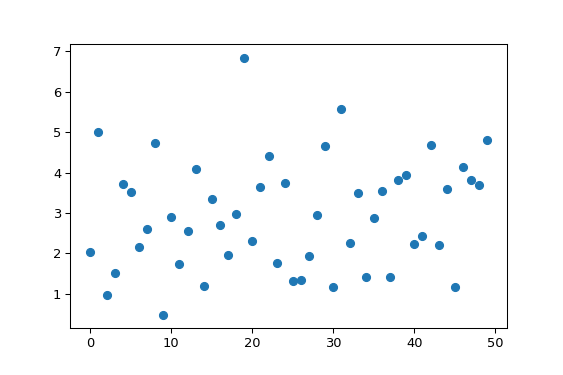

In [129]:
fig,ax = plt.subplots(1,1)
ax.scatter(range(len(errs2)),errs2)
plt.show()